This notebook is used to generate models that represent the LIR or MIR phenotype. This is done by changing some of the parameters that are not estimated. The goal is then to investigate if we find back these changes in the estimated parameters. 

In [22]:
using DifferentialEquations, SciMLBase, Plots, Random, DataStructures, DelimitedFiles, XLSX
using LatinHypercubeSampling
using Trapz
using Dates
using JLD2
using StatsBase
using DataFrames
using CSV

# Include the necessary files
include("./EDES/including.jl")
include("./DataGeneration/AnalyseSynths/SyntheticPatients.jl")
include("./DataGeneration/AnalyseSynths/Realism_inital.jl")
include("./DataGeneration/DiseaseProgression/DiseaseProgressionMIRLIR.jl")
include("./DataGeneration/AnalyseSynths/LocalSensitivity.jl")

# Set the seed for reproducibility
Random.seed!(1234)

TaskLocalRNG()

### generating initial MIR & LIR meal responses

Lets start with 10 MIR people and 10 LIR people

In [2]:
n =10 
BW= 70
parameters_LIR = ["k3", "k4", "G_liv_b"]
parameters_MIR = ["k5"]

# mean values for the parameters
means_LIR = [6.07e-3, 2.35e-4, 0.063]
means_MIR = [0.0424]

# standard deviations for the parameters
lower_deviations_LIR = means_LIR .- (means_LIR .* 0.1 )
upper_deviations_LIR = means_LIR .+ (means_LIR .* 0.1 )
lower_deviations_MIR = means_MIR .- (means_MIR .* 0.1 )
upper_deviations_MIR = means_MIR .+ (means_MIR .* 0.1 )
 
parameter_ranges_LIR = OrderedDict("k3" => (lower_deviations_LIR[1], upper_deviations_LIR[1]),
                                   "k4" => (lower_deviations_LIR[2], upper_deviations_LIR[2]),
                                   "G_liv_b" => (lower_deviations_LIR[3], upper_deviations_LIR[3]))
parameter_ranges_MIR = OrderedDict("k5" => (lower_deviations_MIR[1], upper_deviations_MIR[1]))
fasting_ranges = OrderedDict("fasting_glucose" => (4.8, 5.2), "fasting_insulin" => (7.5, 12.0))

Synthetic_population_LIR = MakePatients(n, parameters_LIR, parameter_ranges_LIR, fasting_ranges, BW = BW);
Synthetic_population_MIR = MakePatients(n, parameters_MIR, parameter_ranges_MIR, fasting_ranges, BW = BW);


Check realism for all the initial patients

In [3]:
boolean_vector = []
for i in 1:length(Synthetic_population_LIR)
    synthetic_patient = Synthetic_population_LIR[i]
    result = ensure_realism_initial(synthetic_patient)
    push!(boolean_vector, result)
end

for i in 1:length(Synthetic_population_MIR)
    synthetic_patient = Synthetic_population_MIR[i]
    result = ensure_realism_initial(synthetic_patient)
    push!(boolean_vector, result)
end

In [4]:
synthetic_patient = Synthetic_population_LIR[1]
synthetic_patient.EDES.estimated_params

3-element Vector{String}:
 "k3"
 "k4"
 "G_liv_b"

### Generating progression towards increased MIR/LIR


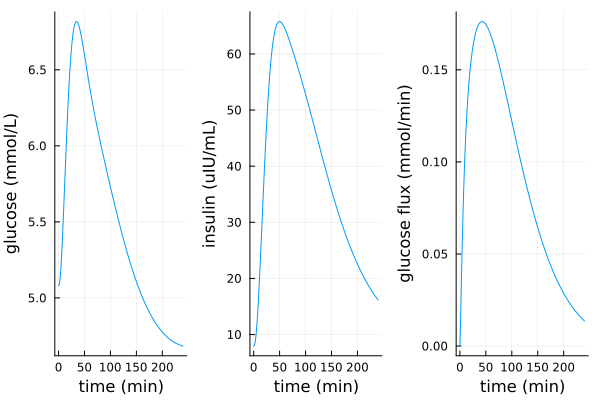

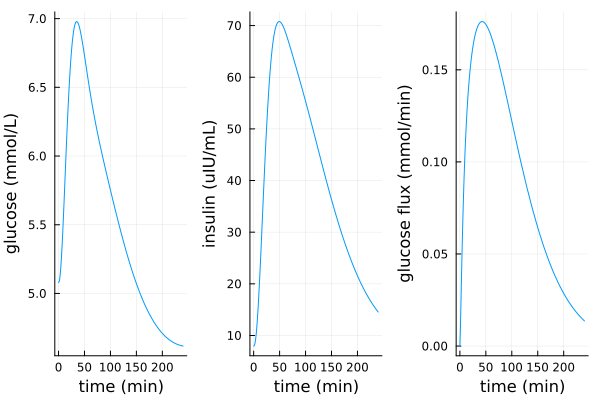

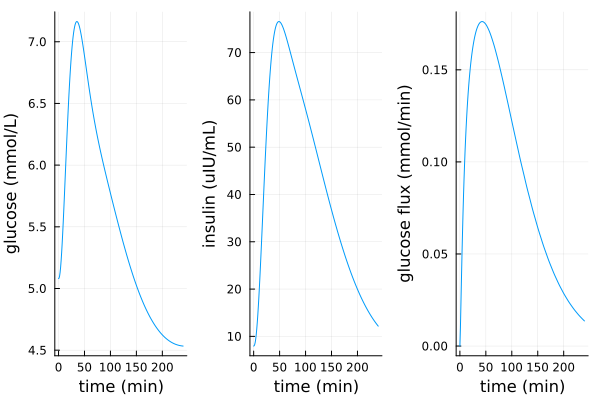

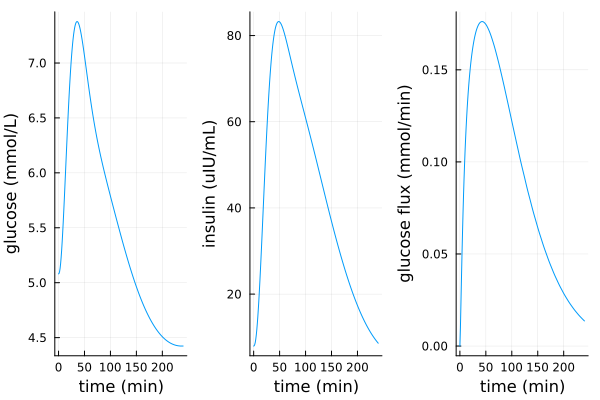

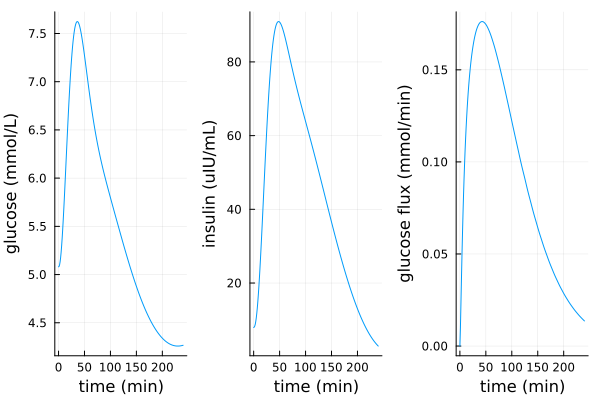

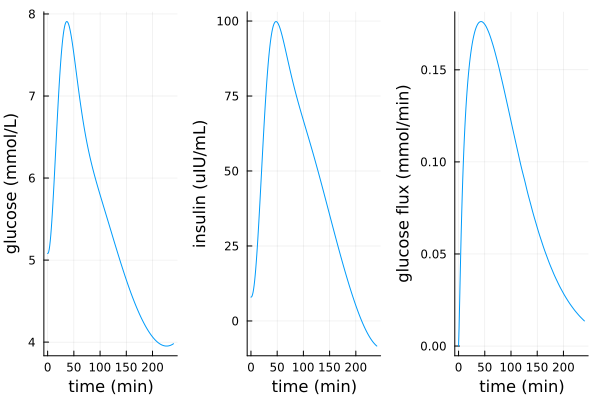

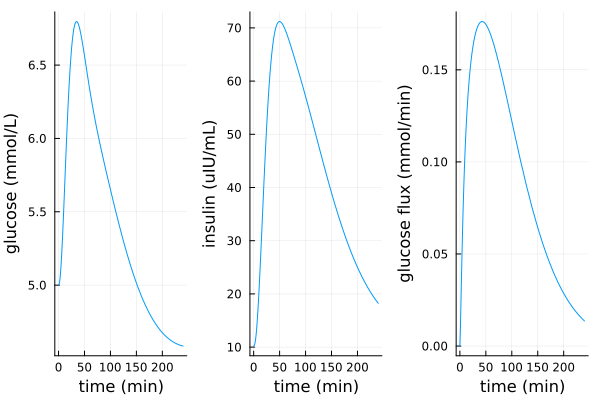

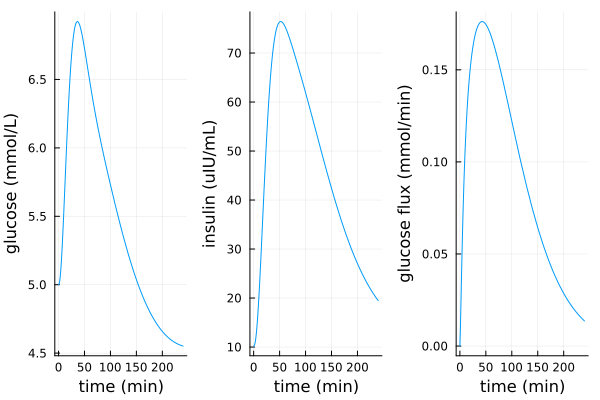

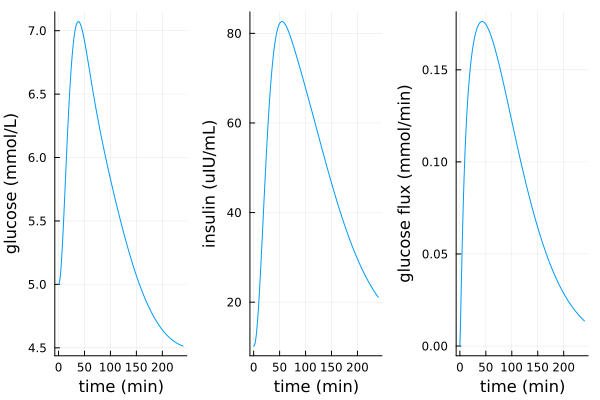

Patient 1
Patient 1
Patient 1
Patient 1
Patient 1
Patient 1


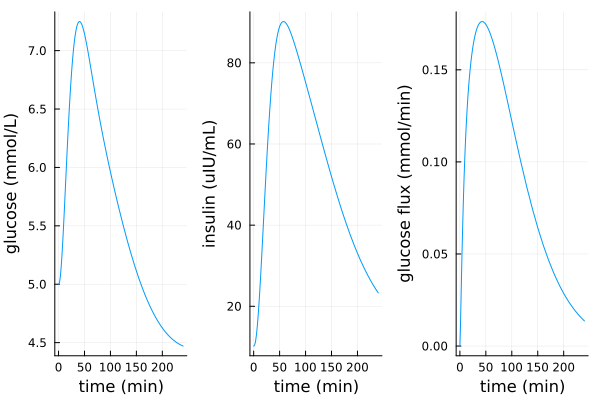

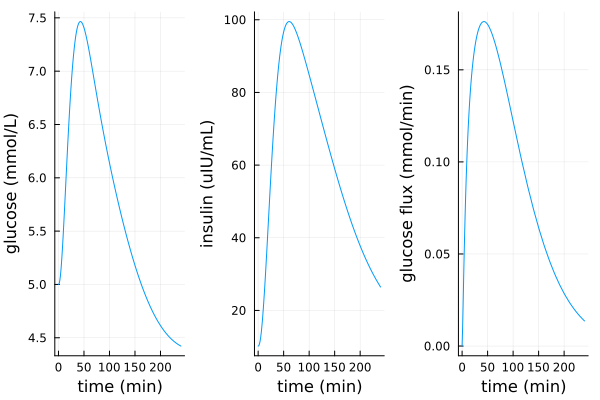

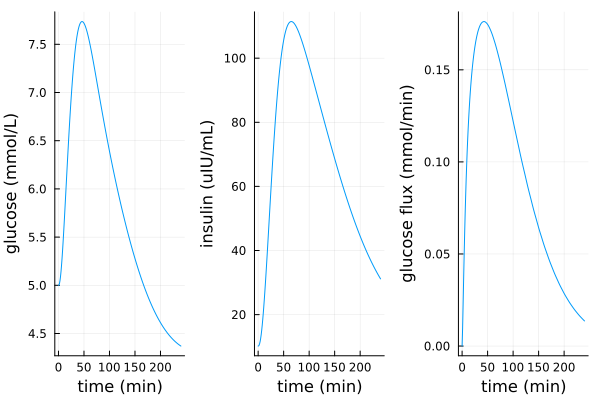

In [5]:
save_bool = true

# Disease progression hyperparameters
k3_linear_LIR = 0.1
k4_linear_LIR = 0.1
G_liv_b_linear_LIR = 1
k5_linear_MIR = 0.1
long_time_points = [0,1,2,3,4,5]
glucose_time_points = [0,15,30,60,120,180,240]
insulin_time_points = [0,15,30,60,120,240]

# initialise output
outputs_glc_LIR = zeros(length(long_time_points), length(glucose_time_points), length(Synthetic_population_LIR))
outputs_ins_LIR = zeros(length(long_time_points), length(insulin_time_points), length(Synthetic_population_LIR))
outputs_glc_MIR = zeros(length(long_time_points), length(glucose_time_points), length(Synthetic_population_MIR))
outputs_ins_MIR = zeros(length(long_time_points), length(insulin_time_points), length(Synthetic_population_MIR))

IDs_LIR = zeros(length(Synthetic_population_LIR) ,length(long_time_points))
IDs_MIR = zeros(length(Synthetic_population_MIR) ,length(long_time_points))

for i in axes(Synthetic_population_LIR, 1)
    synthetic_patient = Synthetic_population_LIR[i]
    IDs_LIR[i,:] .= synthetic_patient.ID

    # change model Parameters
    k3s, k4s, G_liv_bs = LIR_progression(synthetic_patient, long_time_points, k3_linear_LIR, k4_linear_LIR, G_liv_b_linear_LIR)
    for j in axes(long_time_points, 1)
        # copy the parameter values and the model_copy
        parameter_values_copy = copy(synthetic_patient.ParameterValues)
        model_copy = deepcopy(synthetic_patient.EDES)

        # change the parameter values
        parameter_values_copy[1] = k3s[j]
        parameter_values_copy[2] = k4s[j]
        parameter_values_copy[3] = G_liv_bs[j]
        

        if i==1 
            plt = PlotMealResponse(model_copy, parameter_values_copy);
            display(plt)
        end

        if j == 6 && i == 1
            LocalSensitivityAnalysis(model_copy, parameter_values_copy, spread = 0.9)
        end

        glc, ins = SelectTimePoints(model_copy, parameter_values_copy, glucose_time_points, insulin_time_points)

        outputs_glc_LIR[j,:,i] = glc
        outputs_ins_LIR[j,:,i] = ins
    end
end

for i in axes(Synthetic_population_MIR, 1)
    synthetic_patient = Synthetic_population_MIR[i]
    IDs_MIR[i,:] .= synthetic_patient.ID + length(Synthetic_population_LIR) # to make the IDs unique

    # change model Parameters
    k5s = MIR_progression(synthetic_patient, long_time_points, k5_linear_MIR)
    for j in axes(long_time_points, 1)
        # copy the parameter values and the model_copy
        parameter_values_copy = copy(synthetic_patient.ParameterValues)
        model_copy = deepcopy(synthetic_patient.EDES)

        # change the parameter values
        parameter_values_copy[1] = k5s[j]

        if i==1 
            plt = PlotMealResponse(model_copy, parameter_values_copy);
            display(plt)
        end

        if j == 6 && i == 1
            LocalSensitivityAnalysis(model_copy, parameter_values_copy, spread = 0.9)
        end

        glc, ins = SelectTimePoints(model_copy, parameter_values_copy, glucose_time_points, insulin_time_points)

        outputs_glc_MIR[j,:,i] = glc
        outputs_ins_MIR[j,:,i] = ins
    end
end

if save_bool 
    # save the outputs
    date_str = Dates.format(now(), "yyyy-mm-dd")
    time_str = Dates.format(now(), "HH_MM")
    date_time_str = date_str * "-" * time_str
    file_name = "./Results/MIRLIR_patients_$date_time_str.jld2"

    save(file_name,
        "glc_LIR", outputs_glc_LIR,
        "ins_LIR", outputs_ins_LIR,
        "glc_MIR", outputs_glc_MIR,
        "ins_MIR", outputs_ins_MIR,
        "IDs_LIR", IDs_LIR,
        "IDs_MIR", IDs_MIR,
        "k3_linear_LIR", k3_linear_LIR,
        "k4_linear_LIR", k4_linear_LIR,
        "G_liv_b_linear_LIR", G_liv_b_linear_LIR,
        "k5_linear_MIR", k5_linear_MIR,
        "long_time_points", long_time_points,
        "glucose_time_points", glucose_time_points,
        "insulin_time_points", insulin_time_points,
        
    )
end


### Refitting EDES model 

In [13]:
data_MIRLIR = load("./Results/MIRLIR_patients_2024-09-20-11_34.jld2");

In [17]:

# Extract the data
glc_MIR = data_MIRLIR["glc_MIR"]
ins_MIR = data_MIRLIR["ins_MIR"]
glc_LIR = data_MIRLIR["glc_LIR"]
ins_LIR = data_MIRLIR["ins_LIR"]

IDs_MIR = data_MIRLIR["IDs_MIR"]
IDs_LIR = data_MIRLIR["IDs_LIR"]

time_G = data_MIRLIR["glucose_time_points"]
time_I = data_MIRLIR["insulin_time_points"]

IDs_MIR = reshape(IDs_MIR', (60,1))
IDs_LIR = reshape(IDs_LIR', (60,1))
IDs = vcat(IDs_LIR, IDs_MIR)

# combine the data over the third dimension
glc_MIRLIR = cat(glc_LIR, glc_MIR, dims = 3)
ins_MIRLIR = cat(ins_LIR, ins_MIR, dims = 3)

# add a health vector to the data
health = ones(size(IDs))
health[1:(length(long_time_points)*n)] .= 0 # in this case the first 60 patients are LIR patients, so 0 = LIR, 1 = MIR

60-element view(::Vector{Float64}, 1:60) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

### Parameter estimation

In [18]:
using Distributed

n_cores = length(Sys.cpu_info())

# note that this is the same as of the synthetic patients, needs to change if we start changing the weight or the dose
BW = 70 
G_dose::Real = 75000.0


if nprocs()-1 < n_cores
    addprocs(n_cores-nprocs()+1, exeflags="--project")
end

@everywhere begin
    using DifferentialEquations, SciMLBase, Plots, Random # for solving ODEs
    using Optimization, OptimizationOptimJL, LineSearches # for optimization
    using QuasiMonteCarlo # for LHS
    using Trapz
    include("./EDES/including.jl")
end

columnnames = ["ID","Meal Test","Health status","k1","k5","k6", "k8"]
# estimated_parameters = ["k1","k5","k6", "k8"]

# extract the number of meal tests for each patient
counts = countmap(IDs)
n_meal_tests = maximum(values(counts))

patients = [[glc_MIRLIR[j,:,i], ins_MIRLIR[j,:,i], BW, G_dose, time_G, time_I] for i in 1:Int((length(IDs)/n_meal_tests)) for j in 1:n_meal_tests]
results = pmap(x -> ParameterEstimation(x...), patients)

# close the parallel pool
rmprocs(procs()[2:end])

# initialise the dataframe
df_fits = DataFrame()
for col in columnnames
    df_fits[!, Symbol(col)] = Float64[]
end


# Create a vector for meal test numbers
meal_tests = repeat(1:n_meal_tests,Int((length(IDs)/n_meal_tests)))

for i in 1:length(IDs)
    # Add the meal test number, health status, and ID to the start of the result vector
    prepend!(results[i], [IDs[i], meal_tests[i], health[i]])
end

# Fill the dataframe with the results
for i in 1:length(results)
    println(results[i])
    push!(df_fits, transpose(results[i]))
end

      From worker 2:	Optimization successful for this initial set, continuing...
      From worker 2:	Parameter estimation done!
      From worker 4:	Optimization successful for this initial set, continuing...
      From worker 4:	Parameter estimation done!
      From worker 3:	Optimization successful for this initial set, continuing...
      From worker 3:	Parameter estimation done!
      From worker 7:	Optimization successful for this initial set, continuing...
      From worker 7:	Parameter estimation done!
      From worker 8:	Optimization successful for this initial set, continuing...
      From worker 8:	Parameter estimation done!
      From worker 5:	Optimization successful for this initial set, continuing...
      From worker 5:	Parameter estimation done!
      From worker 9:	Optimization successful for this initial set, continuing...
      From worker 9:	Parameter estimation done!
      From worker 10:	Optimization successful for this initial set, continuing...
      From work

In [19]:
first(df_fits)

Row,ID,Meal Test,Health status,k1,k5,k6,k8
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,1.0,0.0,0.0102168,0.0459655,2.36046,4.64885


In [23]:
#save the outputs
date_str = Dates.format(now(), "yyyy-mm-dd")
time_str = Dates.format(now(), "HH_MM")
date_time_str = date_str * "-" * time_str
file_name = "./Results/MIR_LIR_fits_$date_time_str.csv"

CSV.write(file_name, df_fits)

"./Results/MIR_LIR_fits2024-09-20-11_43.csv"

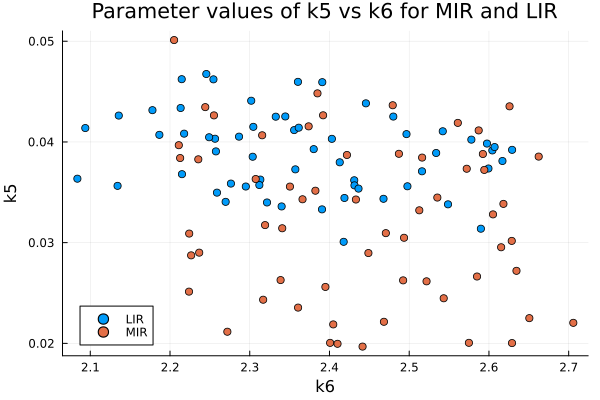

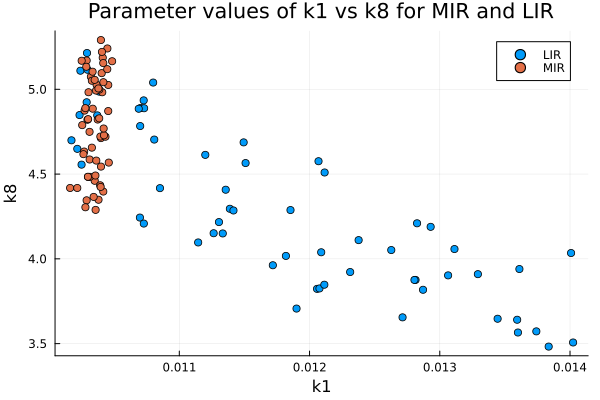

In [24]:
# get LIR parameters
k1_LIR = df_fits[df_fits."Health status" .== 0, "k1"]
k5_LIR = df_fits[df_fits."Health status" .== 0, "k5"]
k6_LIR = df_fits[df_fits."Health status" .== 0, "k6"]
k8_LIR = df_fits[df_fits."Health status" .== 0, "k8"]

# get MIR parameters
k1_MIR = df_fits[df_fits."Health status" .== 1, "k1"]
k5_MIR = df_fits[df_fits."Health status" .== 1, "k5"]
k6_MIR = df_fits[df_fits."Health status" .== 1, "k6"]
k8_MIR = df_fits[df_fits."Health status" .== 1, "k8"]

# plot parameter values of k5 vs k6 for MIR and LIR 
plt_k5k6  =scatter(k6_LIR, k5_LIR, label = "LIR", xlabel = "k6", ylabel = "k5", title = "Parameter values of k5 vs k6 for MIR and LIR")
scatter!(k6_MIR, k5_MIR, label = "MIR")
display(plt_k5k6)

# plot parameter values of k1 vs k6 for MIR and LIR 
plt_k1k8  =scatter(k1_LIR, k8_LIR, label = "LIR", xlabel = "k1", ylabel = "k8", title = "Parameter values of k1 vs k8 for MIR and LIR")
scatter!(k1_MIR, k8_MIR, label = "MIR")
display(plt_k1k8)





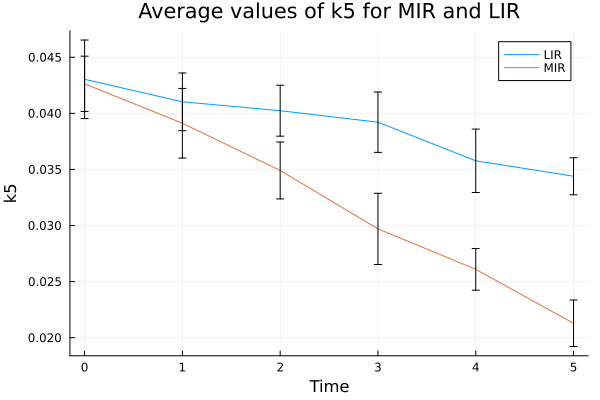

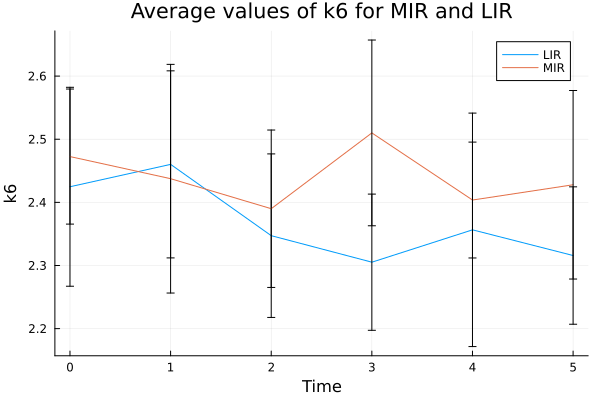

In [25]:
using Plots

# Function to calculate means and stds for a given dataset
function calc_means_stds(data_dict, keys, step)
    means, stds = Dict(), Dict()
    for key in keys
        means[key] = [mean(data_dict[key][i:step:end]) for i in 1:step]
        stds[key] = [std(data_dict[key][i:step:end]) for i in 1:step]
    end
    return means, stds
end

# Dictionary to hold your data (k1_MIR, k1_LIR, etc.)
data_dict = Dict(
    :k1_MIR => k1_MIR, :k1_LIR => k1_LIR, 
    :k5_MIR => k5_MIR, :k5_LIR => k5_LIR, 
    :k6_MIR => k6_MIR, :k6_LIR => k6_LIR, 
    :k8_MIR => k8_MIR, :k8_LIR => k8_LIR
)

# List of the keys to iterate over
data_keys = [:k1_MIR, :k1_LIR, :k5_MIR, :k5_LIR, :k6_MIR, :k6_LIR, :k8_MIR, :k8_LIR]

# Calculate means and standard deviations
means, stds = calc_means_stds(data_dict, data_keys, 6)

function plot_data(x, y1, y2, err_y1, err_y2, ylabel, title)
    plt = plot(x, y1, yerr = err_y1, label = "LIR", xlabel = "Time", ylabel = ylabel, title = title)
    plot!(x, y2, yerr = err_y2, label = "MIR")
    display(plt)
end

# Plot k5 and k6 data
plot_data(long_time_points, means[:k5_LIR], means[:k5_MIR], stds[:k5_MIR], stds[:k5_LIR], "k5", "Average values of k5 for MIR and LIR")
plot_data(long_time_points, means[:k6_LIR], means[:k6_MIR], stds[:k6_MIR], stds[:k6_LIR], "k6", "Average values of k6 for MIR and LIR")
